In [46]:
import pandas as pd
import numpy as np

# text processing
import re
import string 
import contractions 

from sklearn.model_selection import train_test_split

# bert 
from transformers import TFAutoModel, AutoTokenizer
import tensorflow as tf

from tqdm import tqdm
tqdm.pandas()

import logging
logging.basicConfig(format="%(asctime)s - %(levelname)s - %(message)s", level=logging.INFO)

In [2]:
def text_preprocessing(text):
    if not isinstance(text, str):
        text = str(text)
    text = re.sub("\#", " ", text) # remove hashtag # symbol only 
    text = re.sub(r"\\n", " ", text) # remove newlines
    text = text.lower() # text normalization
    text = contractions.fix(text) # fix (expand) contractions
    text = re.sub("\@\w+", " ", text) # remove @
    text = re.sub('\w*\d\w*', " ", text) # remove digits
    text = re.sub("([^\x00-\x7F])+", " ", text) # remove emoji
    text = re.sub('[%s]' % re.escape(string.punctuation), " ", text) # remove punctuation
    text = re.sub("\s+", " ", text) # remove excessive white space 
    return text.strip()

In [3]:
data = pd.read_csv("../data/jigsaw-toxic-comment-classification-challenge/train.csv")

logging.info(f"reading training data, size: {data.shape}")

2023-09-30 19:49:08,338 - INFO - reading training data, size: (159571, 8)


In [4]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
for _, row in data.sample(10).iterrows():
  print("="*150)
  print(row["comment_text"])
  print("-"*50)
  print(text_preprocessing(row["comment_text"]))
  print("="*150)

Tropical cyclones WikiProject Newsletter #2 

The July issue of the WikiProject Tropical cyclones newsletter is now available. If you wish to receive the full newsletter or no longer be informed of the release of future editions, please add your username to the appropriate section on the mailing list.
--------------------------------------------------
tropical cyclones wikiproject newsletter the july issue of the wikiproject tropical cyclones newsletter is now available if you wish to receive the full newsletter or no longer be informed of the release of future editions please add your username to the appropriate section on the mailing list
Obviously he doesn't care what the rules are. You've put a perfect, reasoned position that also quotes the official rules of Wikipedia and he still won't let it go. I can't believe this is actually allowed to happen.He's done the same thing to me.  

http://en.wikipedia.org/wiki/WA_2000
--------------------------------------------------
obviously he

In [6]:
data["text_processed"] = data["comment_text"].progress_apply(text_preprocessing)
data["text_length"] = data["text_processed"].progress_apply(lambda x: len(x.split(" ")))

logging.info(f'min text len: {min(data["text_length"])}, max: {max(data["text_length"])}')

  0%|          | 0/159571 [00:00<?, ?it/s]

100%|██████████| 159571/159571 [00:00<00:00, 451460.80it/s]
2023-09-30 19:49:28,809 - INFO - min text len: 1, max: 1403


In [7]:
data["text_length"].describe()

count    159571.000000
mean         67.950279
std         100.623431
min           1.000000
25%          17.000000
50%          36.000000
75%          76.000000
max        1403.000000
Name: text_length, dtype: float64

In [8]:
q_tiles = np.array(range(75, 100, 5))/100
q_numbers = np.quantile(data["text_length"].values, q_tiles)

logging.info(f"data distribution (quantile, text_length) is: \n{[(t,  n) for n, t in zip(q_numbers, q_tiles)]}")

2023-09-30 19:49:31,212 - INFO - data distribution (quantile, text_length) is: 
[(0.75, 76.0), (0.8, 92.0), (0.85, 115.0), (0.9, 154.0), (0.95, 232.0)]


<Axes: >

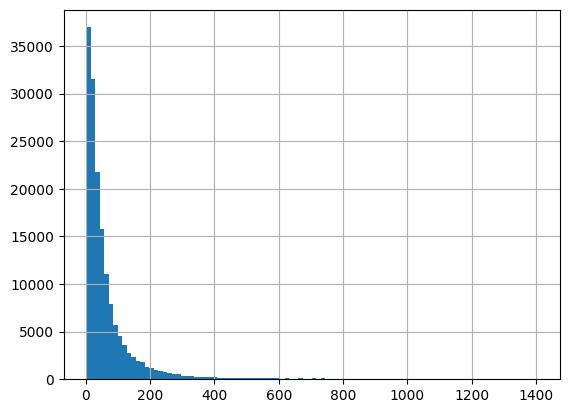

In [9]:
data["text_length"].hist(bins=100)

In [10]:
data.loc[np.argmax(data["text_length"].values), "text_processed"]

'do go fuck off bastard do yyou have a life go fuck off bastard and yank your cock through your ass i hate you and hope you go away forever lame is you fuck your mom die die die and all that crap this is for mahy mahonerz ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass i ass 

In [33]:
labels = [label for label in data.columns if label not in ["id", "comment_text", "text_processed", "text_length"]]
num_labels = len(labels)

<Axes: >

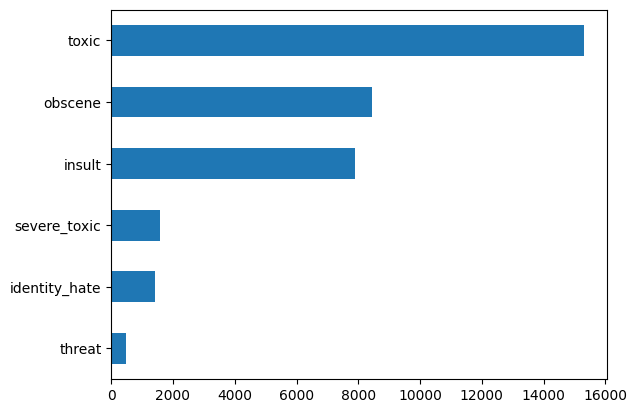

In [44]:
data[labels].sum().sort_values().plot.barh()

In [47]:
X_train, X_val, y_train, y_val = train_test_split(data["text_processed"], data[labels], test_size=0.2)

In [28]:
model_id = "bert-base-uncased"
max_length = 256
batch_size = 32
learning_rate = 3e-5

tokenizer = AutoTokenizer.from_pretrained(model_id)
bert_model = TFAutoModel.from_pretrained(model_id)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

array(['by the way i direct all interested editors to the first section on this page which satyrtn has tried unsuccessfully to archive before consensus there you will see many other editors responses to these same arguments which satyrtn was also making three months ago',
       'that is sooooo wrong',
       'the question of censorship is a legitimate issue on this page though it looks like one huge list of wikilinks at this time it appears there were three separate incidents of cutting which occured on the american broadcast but did not occur on the canadian broadcast the sally field acceptance speech the katherine heigl expletive of surprise an off color joke made by ray romano while wikipedia is not a newsroom and perhaps the information would best be gathered at wikinews this issue deserves some treatment and this page space is exactly where that treatment belongs it is not a partisan issue because imho the broadcaster in each case can be said to have acted in the interest of prev

In [53]:
type(X_train.to_list())

list

In [54]:
# tokenization
train_tokens = tokenizer.batch_encode_plus(X_train.to_list(),
                                      max_length=max_length,
                                      padding="max_length",
                                      truncation=True,
                                      add_special_tokens=True,
                                      return_tensors="tf"
                                      )

val_tokens = tokenizer.batch_encode_plus(X_val.to_list(),
                                      max_length=max_length,
                                      padding="max_length",
                                      truncation=True,
                                      add_special_tokens=True,
                                      return_tensors="tf"
                                      )


In [55]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_tokens, y_train)).shuffle(1000).batch(batch_size, drop_remainder=False)
val_dataset = tf.data.Dataset.from_tensor_slices((val_tokens, y_val)).shuffle(1000).batch(batch_size, drop_remainder=False)

In [32]:
# build model

input_ids = tf.keras.layers.Input(shape=(max_length, ),
                                  name="input_ids",
                                  dtype="int32"
                                  )
attention_mask = tf.keras.layers.Input(shape=(max_length, ),
                                       name="attention_mask",
                                       dtype="int32"
                                       )
token_type_ids = tf.keras.layers.Input(shape=(max_length, ),
                                       name="token_type_ids",
                                       dtype="int32"
                                       )

embedding = bert_model(
  input_ids = input_ids,
  attention_mask = attention_mask,
  token_type_ids = token_type_ids,
)["pooler_output"]

embedding.trainable = True
output1 = tf.keras.layers.Dense(1024, activation="relu")(embedding)
output2 = tf.keras.layers.Dropout(0.3)(output1)
output3 = tf.keras.layers.Dense(256)(output2)
output4 = tf.keras.layers.Dense(len(labels), activation="sigmoid", name="output")(output3)
model = tf.keras.Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=output4)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.BinaryCrossentropy()
metric = tf.keras.metrics.CategoricalAccuracy()

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[metric]
              )

print(model.summary())



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 token_type_ids (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                            